# David Fox - EV usage and revenue data exploration
By performing dataframe manipulations, aggregations, and basic investigations I evaluate the differences in revenue over the different station locations

In [180]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.multioutput import MultiOutputRegressor

from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.model_selection import cross_val_score, GridSearchCV, TimeSeriesSplit


from sklearn.impute import SimpleImputer

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error, explained_variance_score
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.metrics import make_scorer

from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator


from scipy.stats import kruskal, pearsonr, randint, uniform, chi2_contingency, boxcox


import datetime

from sklearn import set_config
set_config(display='diagram') 

plt.rcParams['figure.figsize'] = [20, 20]

sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')


sns.set(rc={'figure.figsize':(20, 10)})
sns.set_context("poster")
sns.set_style("white")
palette = sns.color_palette("mako_r", 6)

In [566]:
def import_data():
    # charging session data 
    
    df1 = pd.read_csv('data/Fort Collins Utilities EV Data June 2020 to June 2021.csv')
    df2 = pd.read_csv('data/Fort Collins Utilities EV Data June 25 2021 to July 20 2021.csv')
    df3 = pd.read_csv('data/FCU EV Charging Transaction Data July 20 2021 to Sept 2021.csv')
    
    charging_df = pd.concat([df1, df2, df3])
    charging_df = charging_df.rename(columns={'Session/Reservation Start Date': 'Date'})
    charging_df = ( charging_df.set_index(pd.to_datetime(charging_df['Date']))
                               .groupby('Station Name')
                               .resample('1D').sum()
                               .reset_index()
                  )
                  
    
    weather_df = pd.read_csv('data/weather.csv')
    weather_df = weather_df.rename(columns={'DATE':'Date'})
    weather_df['Date'] = pd.to_datetime(weather_df['Date'])
            
        
    df_covid = pd.read_csv('data/cases100k-7-day-rate.csv')
    df_covid = df_covid.rename(columns={"Cases/100K: 7-Day":"cases_per_100k"})
    df_covid['Date'] = pd.to_datetime(df_covid.DateTime).dt.strftime("%Y-%m-%d")
    df_covid['Date'] = pd.to_datetime(df_covid.Date)
   
                 
    df = (charging_df.merge(weather_df, on='Date', how='inner')
                     .merge(df_covid, on='Date', how='inner')
         )
    

    
    return df

In [567]:
df = import_data()

In [568]:
df = (df.set_index(pd.to_datetime(df['Date']))
         .dropna(how='all')
     )

In [569]:
df.dtypes

Station Name                        object
Date                        datetime64[ns]
Energy (kWh)                       float64
Gross Amount                       float64
Flex Billing Service Fee           float64
Net Revenue                        float64
Exchange Rate (USD1.000)           float64
STATION                             object
NAME                                object
LATITUDE                           float64
LONGITUDE                          float64
ELEVATION                          float64
PRCP                               float64
SNOW                               float64
SNWD                               float64
TMAX                               float64
TMIN                               float64
TOBS                               float64
WT03                               float64
DateTime                            object
cases_per_100k                     float64
dtype: object

In [553]:
df.isnull().sum()

Station Name                   0
Date                           0
Energy (kWh)                   0
Gross Amount                   0
Flex Billing Service Fee       0
Net Revenue                    0
Exchange Rate (USD1.000)       0
STATION                        0
NAME                           0
LATITUDE                       0
LONGITUDE                      0
ELEVATION                      0
PRCP                           0
SNOW                           0
SNWD                           0
TMAX                           0
TMIN                           0
TOBS                           0
WT03                        3407
dtype: int64

In [556]:
df.Date

Date
2020-06-25   2020-06-25
2020-06-26   2020-06-26
2020-06-26   2020-06-26
2020-06-27   2020-06-27
2020-06-27   2020-06-27
                ...    
2021-09-21   2021-09-21
2021-09-21   2021-09-21
2021-09-21   2021-09-21
2021-09-21   2021-09-21
2021-09-21   2021-09-21
Name: Date, Length: 3435, dtype: datetime64[ns]

# Plot the revenue for each station over time

In [294]:
df2 =  ( df.groupby('Station Name')['Net Revenue'].resample('1D').sum().reset_index()
             .assign(Station_Name = lambda x: x['Station Name'].str.replace('FORT COLLINS /',''))
             .set_index('Date')
             .assign(Date = lambda x: x.index)
        )



In [295]:
df2['revenue_7D'] = df2.groupby('Station Name')['Net Revenue'].transform(lambda x: 
                                                      x.rolling('7D', closed='both', center=True).mean())

In [296]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3451 entries, 2020-06-25 to 2021-09-21
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Station Name  3451 non-null   object        
 1   Net Revenue   3451 non-null   float64       
 2   Station_Name  3451 non-null   object        
 3   Date          3451 non-null   datetime64[ns]
 4   revenue_7D    3451 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 161.8+ KB


### Weekly moving average applied to the revenue generated from each of the stations

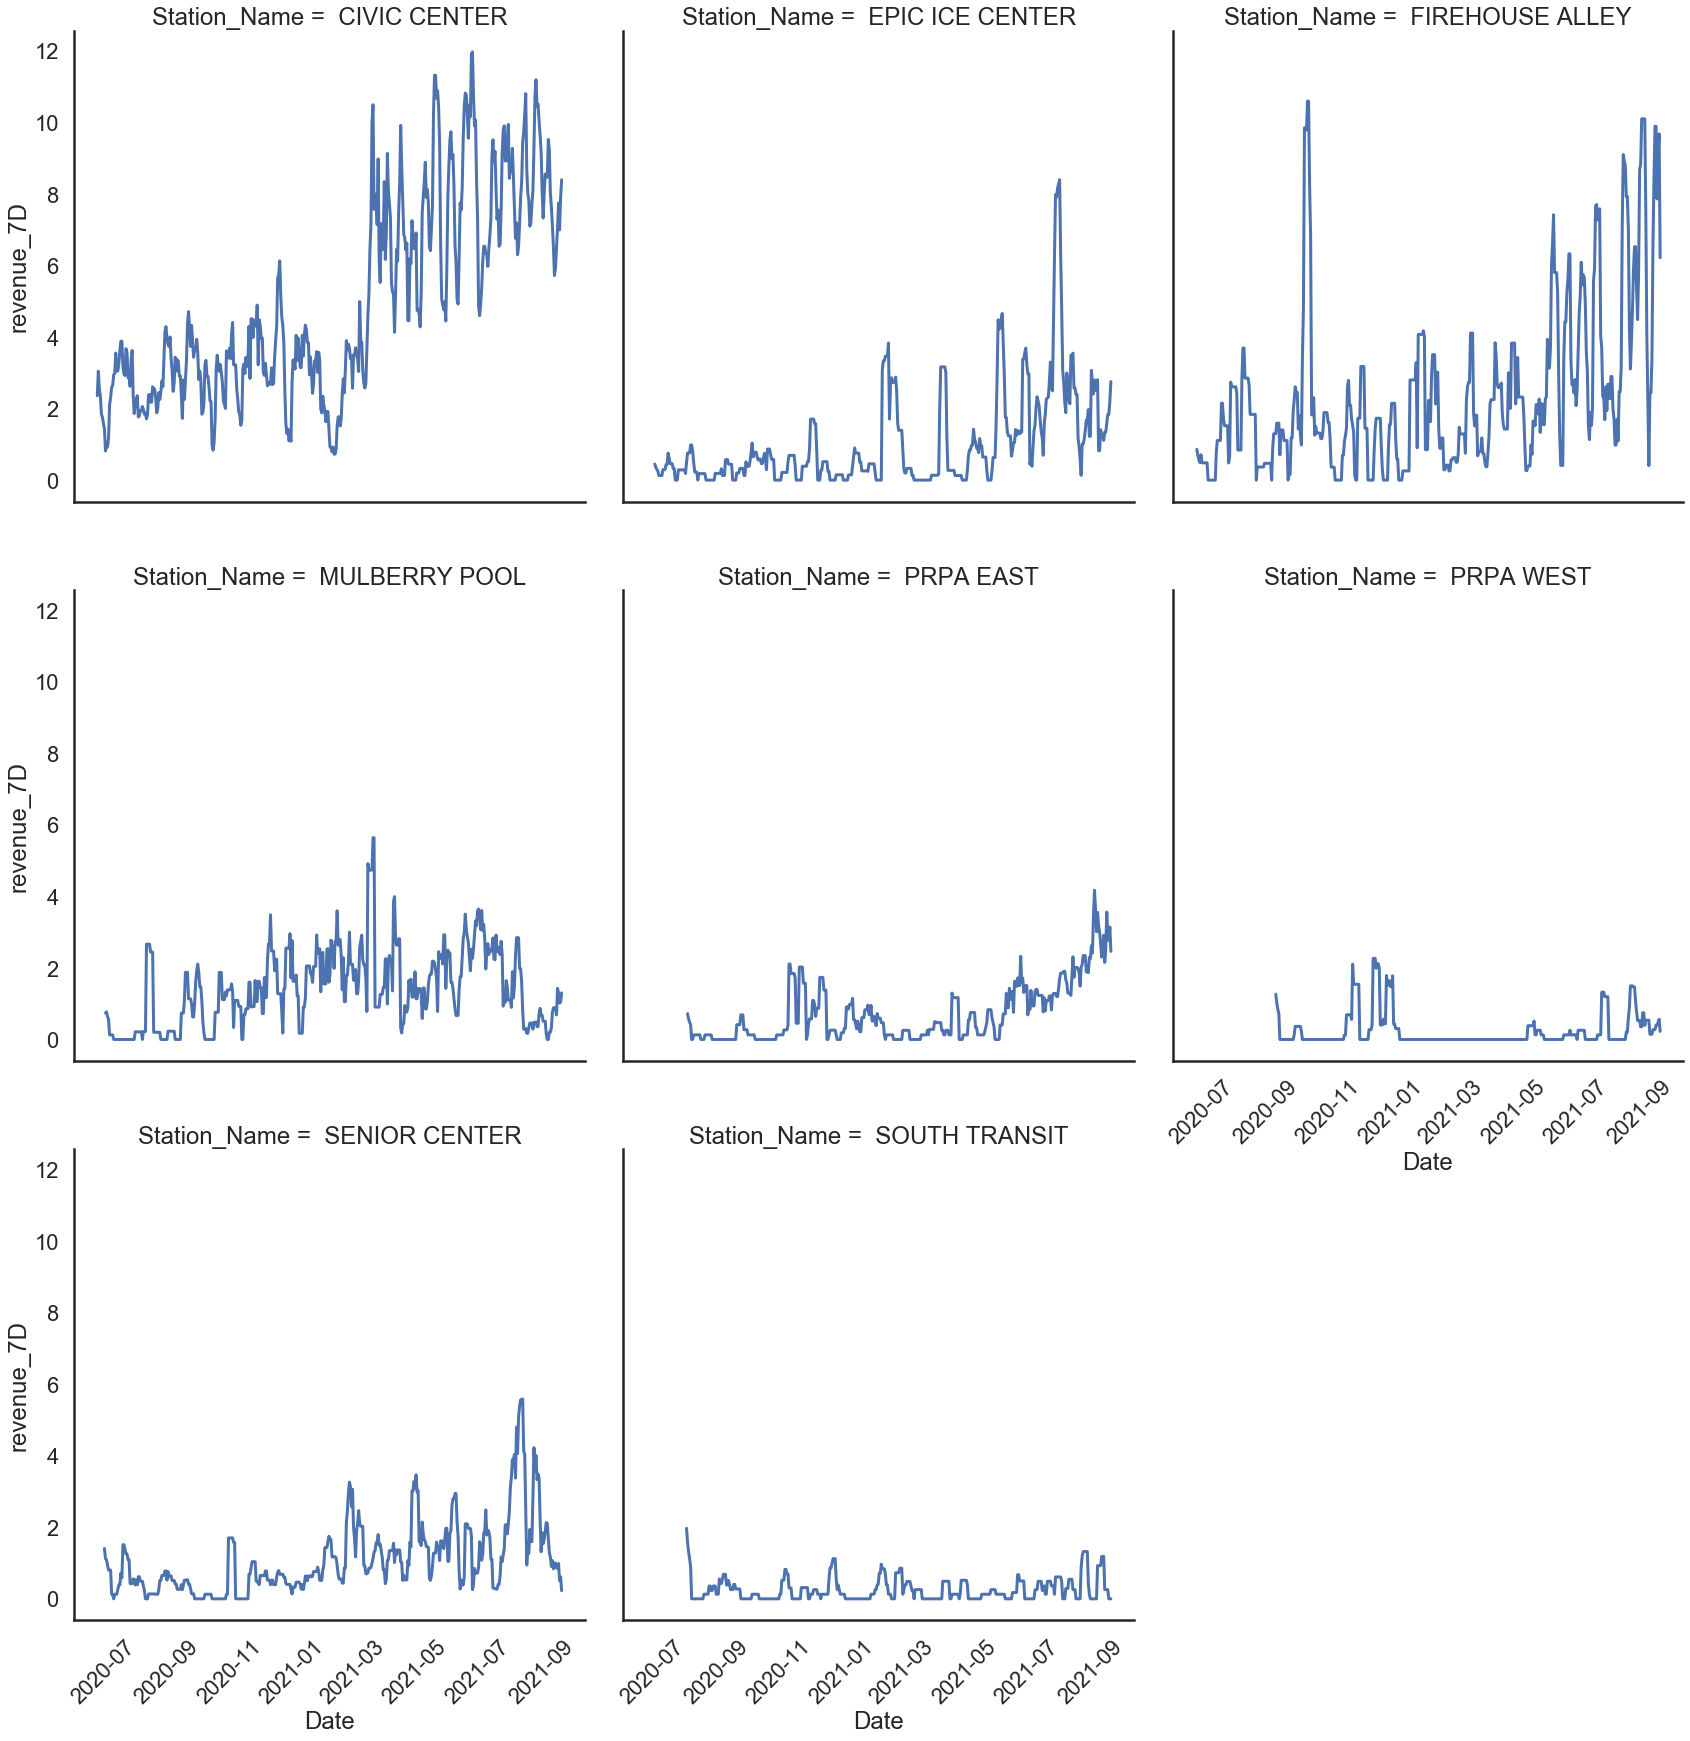

In [297]:
with sns.axes_style("white"):
    g = sns.FacetGrid(df2, col="Station_Name", margin_titles=True, 
                      height=8, sharey=True, col_wrap=3)
    
g.map(sns.lineplot, "Date", "revenue_7D")

for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=45);
    

# Now I will perform some more aggregations to obtain weekly stats over the stations to identify the best and worst performing stations

In [61]:
test =  df.groupby('Station Name')['Net Revenue'].resample('1D').size().reset_index()

In [62]:
last7days = test[test["Date"] >= (test.iloc[-1]['Date'] - pd.Timedelta(days=7))]

Text(0.5, 1.0, 'number of visits at each station over the last week')

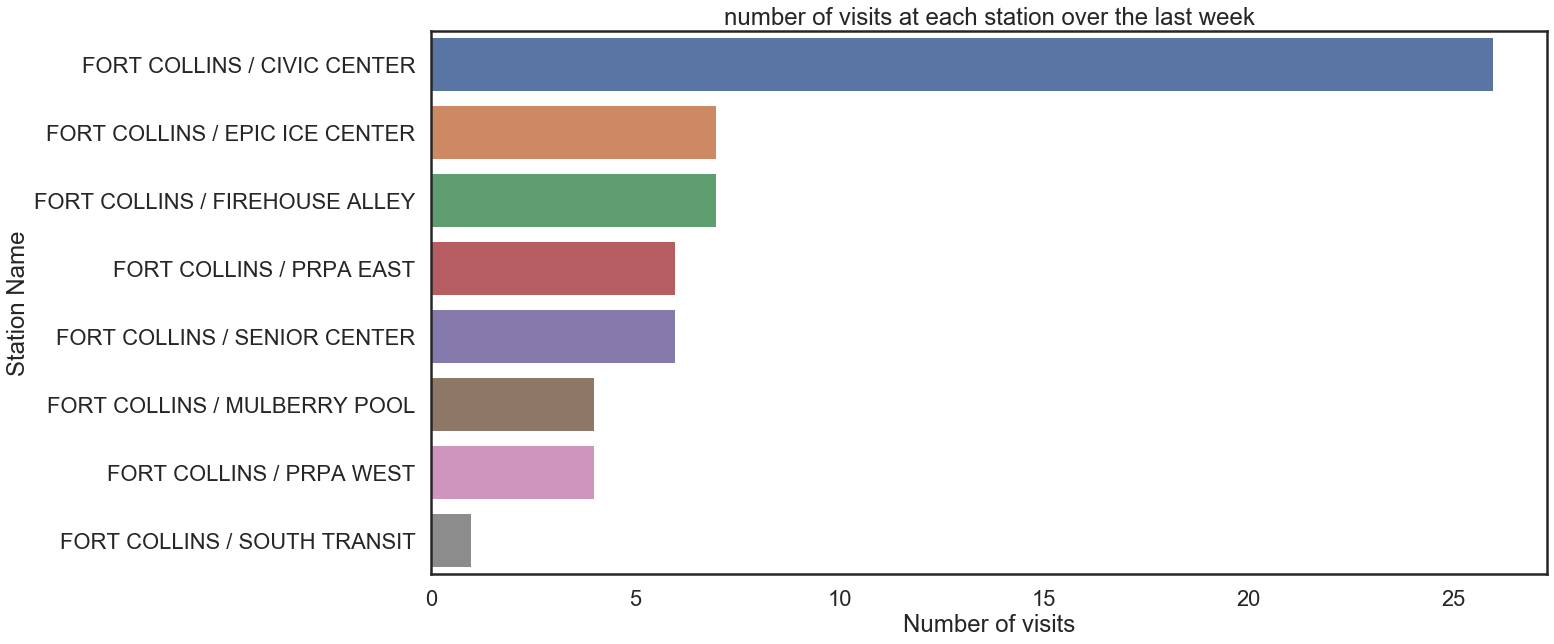

In [63]:
test2 = ( last7days.groupby('Station Name')['Net Revenue'].sum()
                                                     .reset_index()
                                                     .rename(columns={'Net Revenue' : 'Number of visits'})
                                                     .sort_values(by='Number of visits', ascending=False)
        )
ax = sns.barplot(x="Number of visits", y="Station Name", data=test2, capsize=.2)    
plt.title("number of visits at each station over the last week")

### civic center is getting 26 sessions in the last week, whereas the station at South Transit is hardly being used! This station is probably not worth the money!
The next lowest are PRPA west and Mulberry pool. Inspecting the revenue over time, it looks like PRPA west is consistently low, but the station at Mulberry pool seems to be experiencing only a temporary decrease in revenue.

# Show weekly revenue from each station in the last week

In [73]:
last7days = df2[df2["Date"] >= (df2.iloc[-1]['Date'] - pd.Timedelta(days=7))]


Text(0.5, 1.0, 'Weekly Total Revenue By Station')

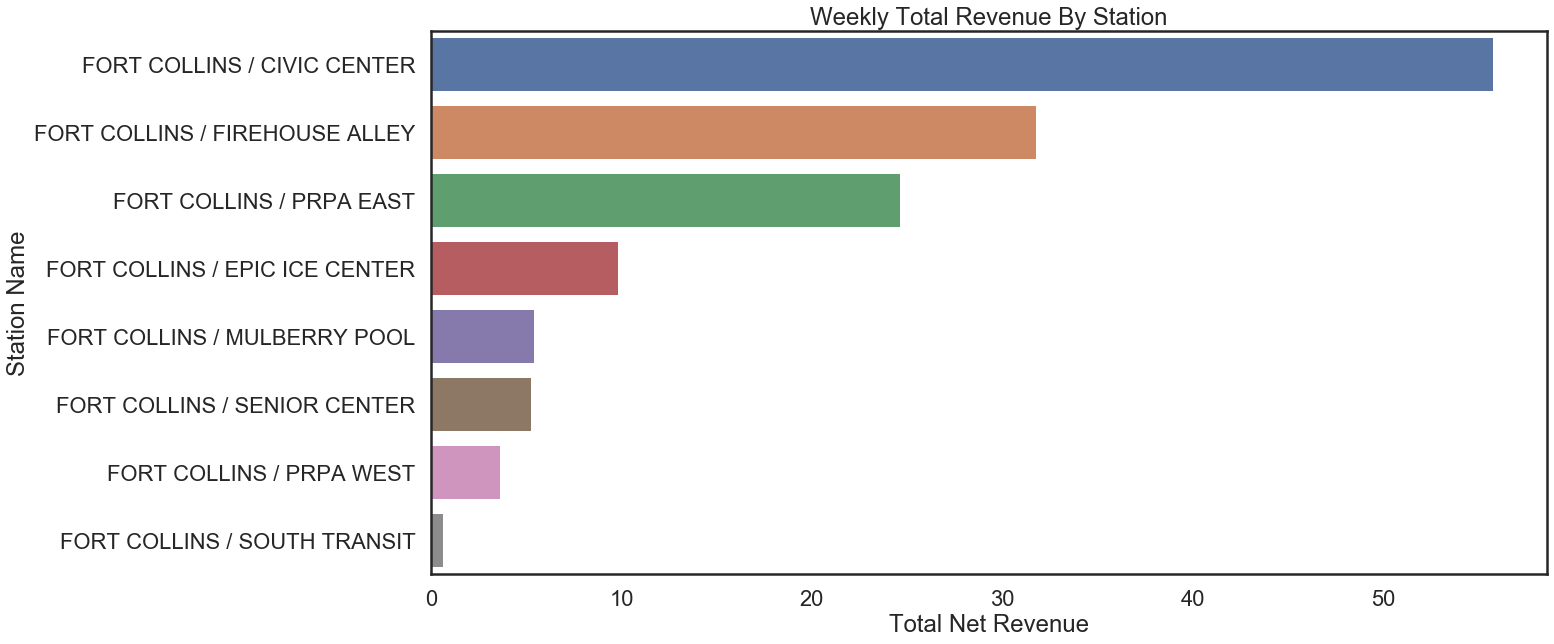

In [75]:
test2 = ( last7days.groupby('Station Name')['revenue_7D'].sum()
                                                     .reset_index()
                                                     .rename(columns={'revenue_7D' : 'Total Net Revenue'})
                                                     .sort_values(by='Total Net Revenue', ascending=False)
        )
ax = sns.barplot(x="Total Net Revenue", y="Station Name", data=test2, capsize=.2)   
plt.title('Weekly Total Revenue By Station')

# plot the average duration of charging sessions per station and per weekday and weekend

In [76]:
df['duration'] = (pd.to_datetime(df['Session/Reservation End Date'].str[:-6]) - pd.to_datetime(df['Date'])) / pd.Timedelta(hours=1)

In [77]:
test =  df.groupby('Station Name')['duration'].resample('1D').mean().reset_index()

In [88]:
last7days = test[test["Date"] >= (test.iloc[-1]['Date'] - pd.Timedelta(days=7))]

In [89]:
last7days['is_weekend'] = last7days['Date'].dt.dayofweek > 4

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'Average duration By Station over the last week')

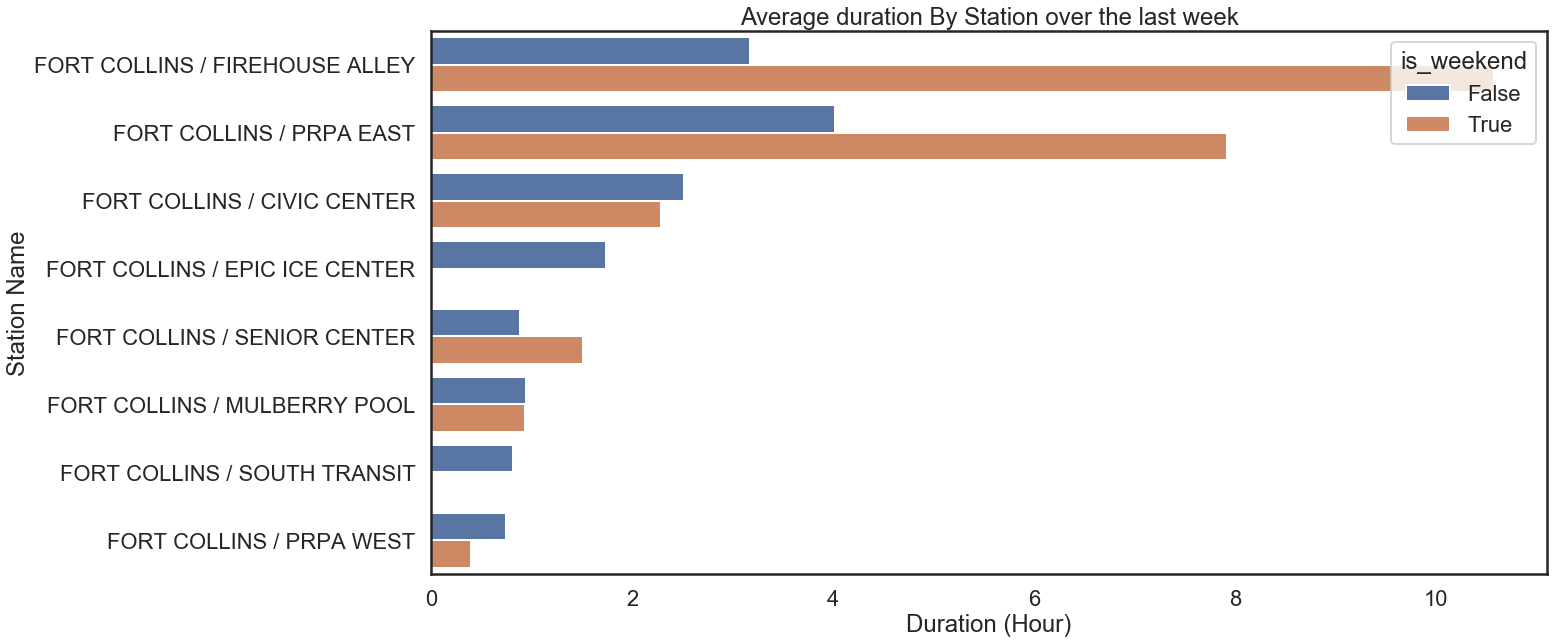

In [92]:
test2 = ( last7days.groupby(['Station Name', 'is_weekend'])['duration'].mean()
                                                     .reset_index()
                                                     .rename(columns={'duration' : 'Duration (Hour)'})
                                                     .sort_values(by='Duration (Hour)', ascending=False)
        )
ax = sns.barplot(x="Duration (Hour)", y="Station Name", hue='is_weekend', data=test2, capsize=.2)   
plt.title('Average duration By Station over the last week')

### individual charging sessions are the same or longer on the weekend compared to that for the working weekday.
This is the case for the following stations:
- Firehouse Alley
- PRPA East
- Civic Center
- Senior Center
- Mulberry Pool

For some reason in the last week, the stations located at the ice center and south transit were not used on the weekend. PRPA West station seems to be used more during weekdays suggesting to me that it is not located close to places of public gathering or local business.


# Total amount of money collected from individually and collectively is larger during the summer months.
This is why month of the year should be included as a feature

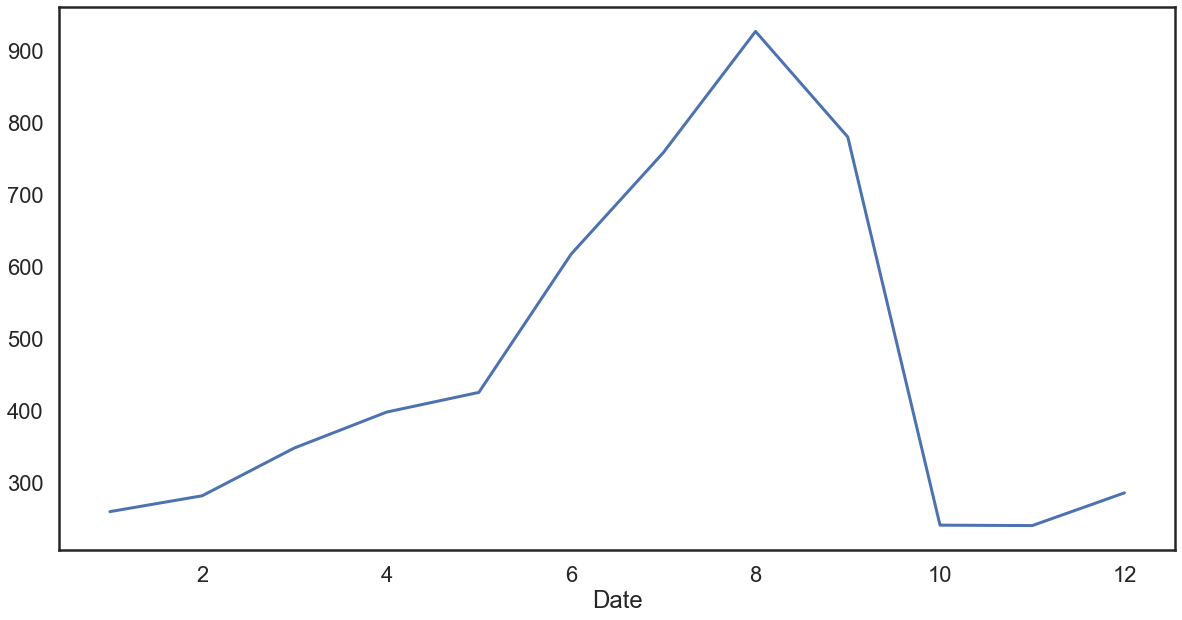

In [116]:
df2.groupby(df2.Date.dt.month)['revenue_7D'].sum().plot()


In [164]:
revenue_per_year = ( df2.groupby(['Station Name', df2.Date.dt.month])['revenue_7D']
                        .mean()
                        .unstack(level=0)
                        .reset_index()
                   )

In [165]:
revenue_per_year = ( pd.melt(revenue_per_year, id_vars="Date")
                        .rename(columns={'value': "revenue ($)"})
                   )

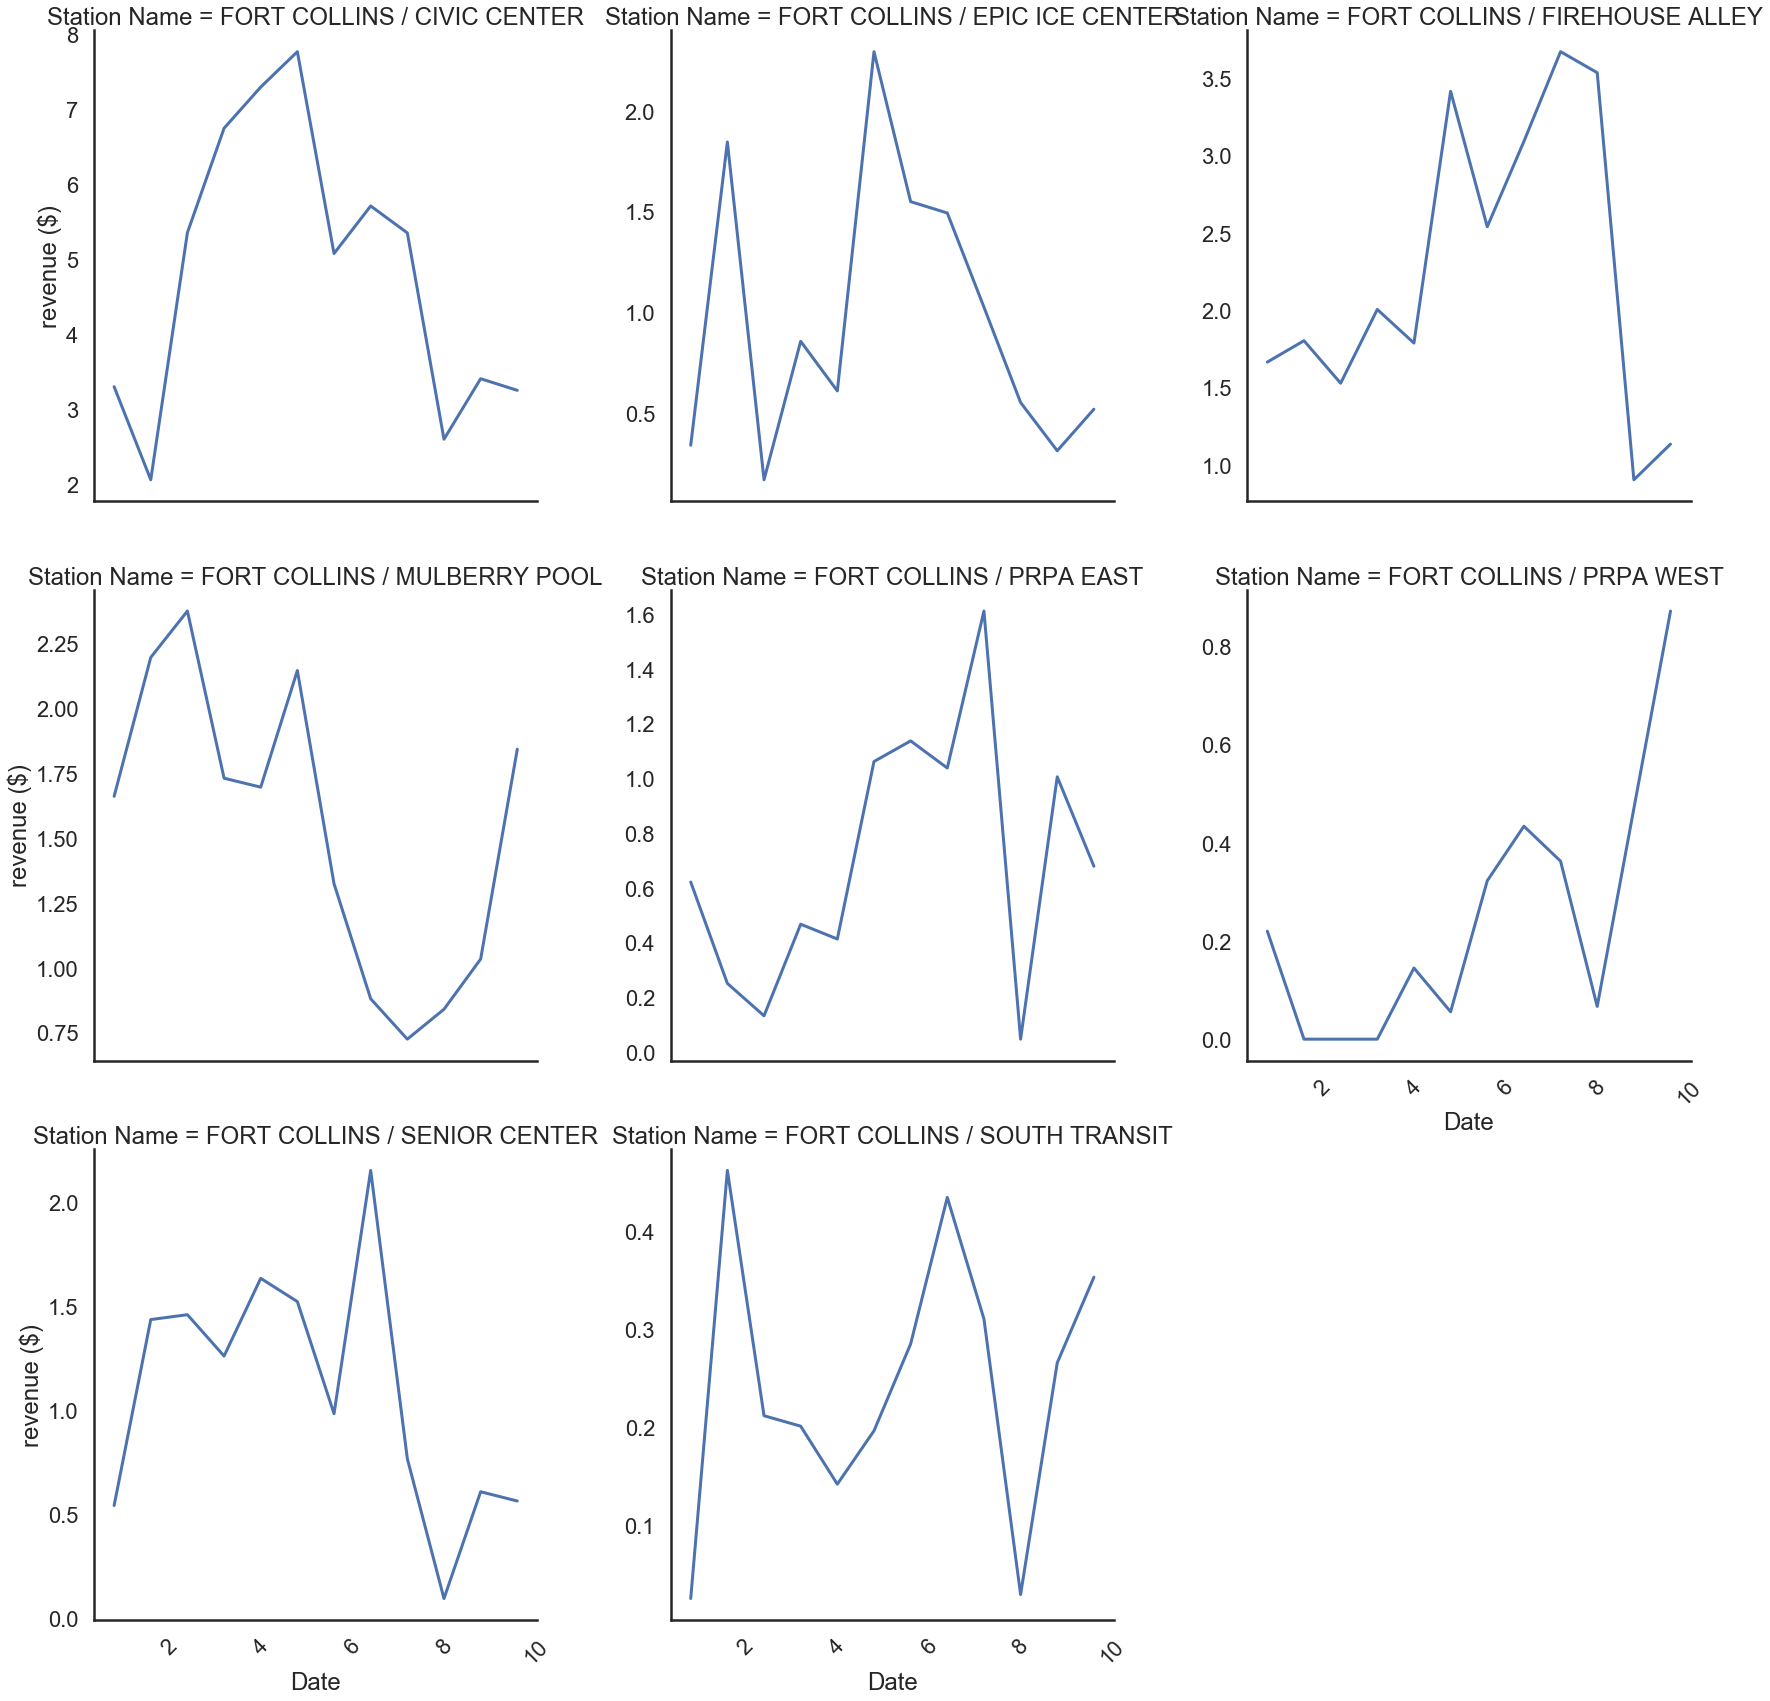

In [166]:
with sns.axes_style("white"):
    g = sns.FacetGrid(revenue_per_year, col="Station Name", margin_titles=True, 
                      height=8, sharey=False, col_wrap=3)
    
g.map(sns.lineplot, "Date", "revenue ($)")
for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=45);
    
g.add_legend()

In [161]:
revenue_per_year = ( df2.groupby(['Station Name', df2.Date.dt.dayofweek])['revenue_7D']
                        .mean()
                        .unstack(level=0)
                        .reset_index()
                   )

In [162]:
revenue_per_year = ( pd.melt(revenue_per_year, id_vars="Date")
                        .rename(columns={'value': "revenue ($)"})
                   )

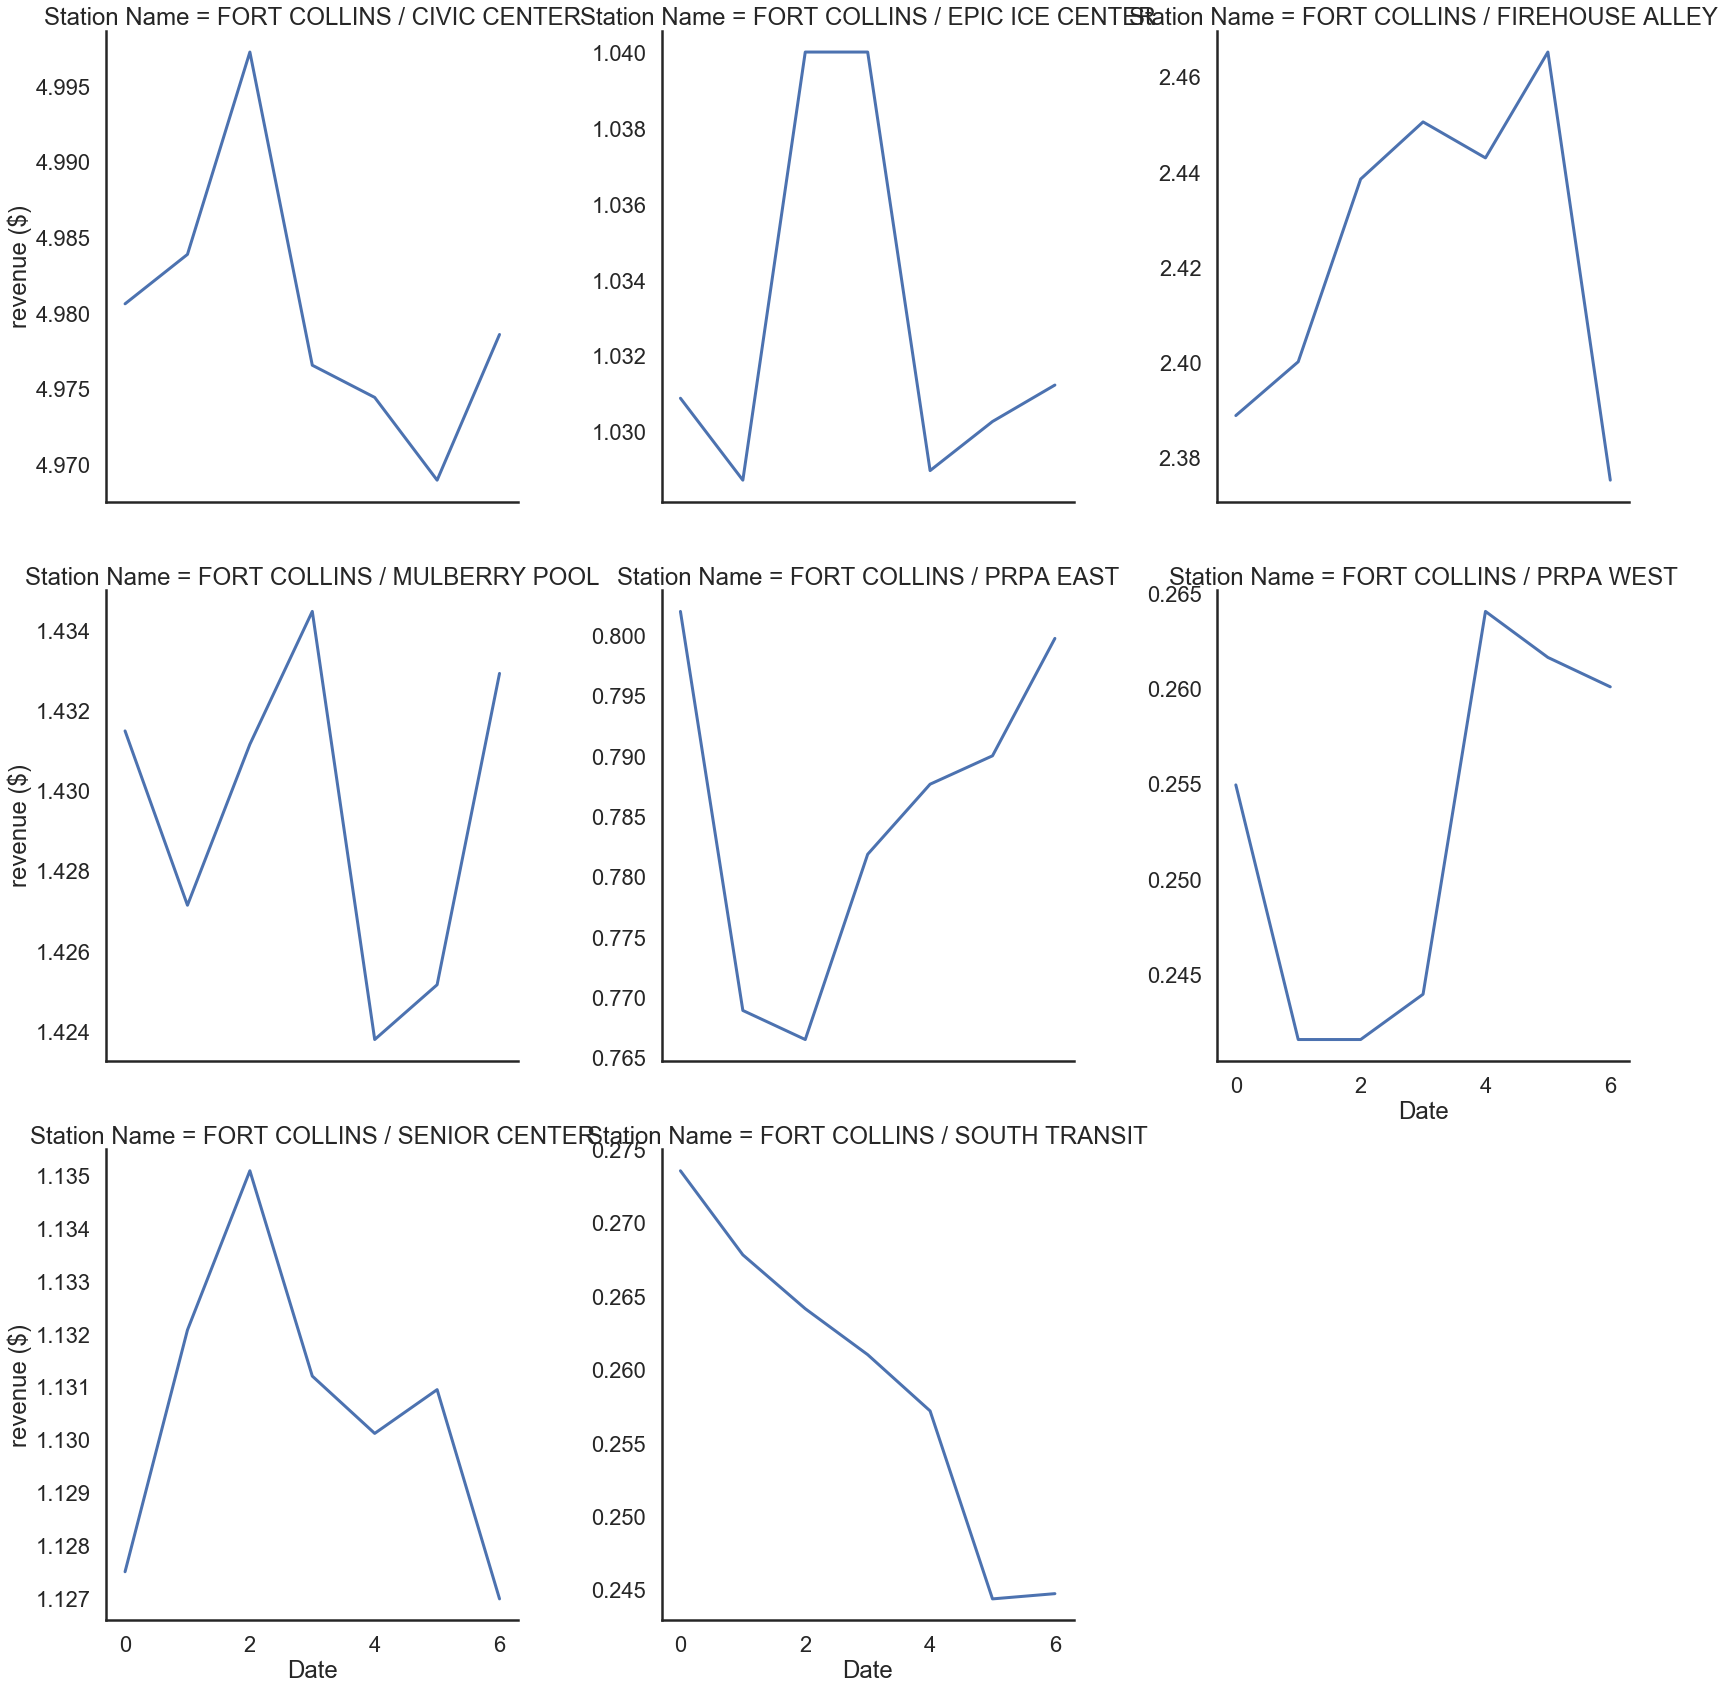

In [163]:
with sns.axes_style("white"):
    g = sns.FacetGrid(revenue_per_year, col="Station Name", margin_titles=True, 
                      height=8, sharey=False, col_wrap=3)
    
g.map(sns.lineplot, "Date", "revenue ($)")


# Stations make more money on holidays (Christmas and New year)

In [481]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
usb = CustomBusinessDay(calendar = USFederalHolidayCalendar())
holidays = pd.date_range('12/1/2020', '1/5/2021', freq=usb)

In [482]:
df3 = (df['Net Revenue']
       .resample('1D')
       .sum()
       .reset_index()
)

In [483]:
df3['Holiday'] = ~df3['Date'].isin(holidays)


In [484]:
df3.groupby('Holiday')['Net Revenue'].mean()

Holiday
False     9.999583
True     12.003953
Name: Net Revenue, dtype: float64

In [485]:
# Correlation between holiday feature and the number of customers per day
# using the Kruskal Wallis H test for correlations between a continuous and categorical variable
kruskal(df3['Holiday'], df3['Net Revenue'])

KruskalResult(statistic=608.4163117667821, pvalue=2.472892771183808e-134)

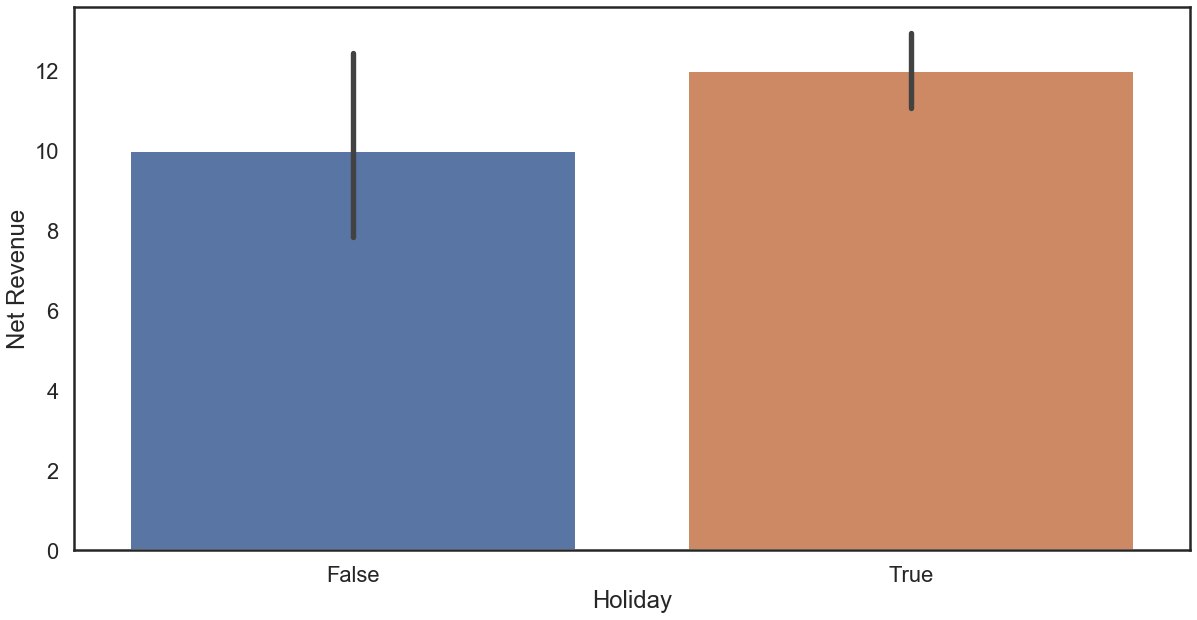

In [486]:


# plotting the customer statistics in form of a boxplot for the holiday feature
sns.barplot(data = df3, x='Holiday', y='Net Revenue');



In [347]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3435 entries, 2020-06-25 to 2021-09-21
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Station Name              3435 non-null   object        
 1   Date                      3435 non-null   datetime64[ns]
 2   Energy (kWh)              3435 non-null   float64       
 3   Gross Amount              3435 non-null   float64       
 4   Flex Billing Service Fee  3435 non-null   float64       
 5   Net Revenue               3435 non-null   float64       
 6   Exchange Rate (USD1.000)  3435 non-null   float64       
 7   STATION                   3435 non-null   object        
 8   NAME                      3435 non-null   object        
 9   LATITUDE                  3435 non-null   float64       
 10  LONGITUDE                 3435 non-null   float64       
 11  ELEVATION                 3435 non-null   float64       
 12  PR

In [300]:
# check what the correlation between the different temperature features and total_revenue is

In [421]:
df3 = (df['Net Revenue']
       .resample('1D')
       .sum()
       .reset_index()
)

In [429]:
df3['TOBS'] = (df['TOBS']
       .resample('1D')
       .mean()
       .reset_index()
)['TOBS']

In [434]:
df3 = df3.dropna()

In [441]:
print('temp_avg:', pearsonr(reduced_df['TOBS'], reduced_df['Net Revenue']))

temp_avg: (0.34675585763937256, 4.293151930825981e-07)


In [439]:
reduced_df = (df3[['TOBS','Net Revenue']][250:])

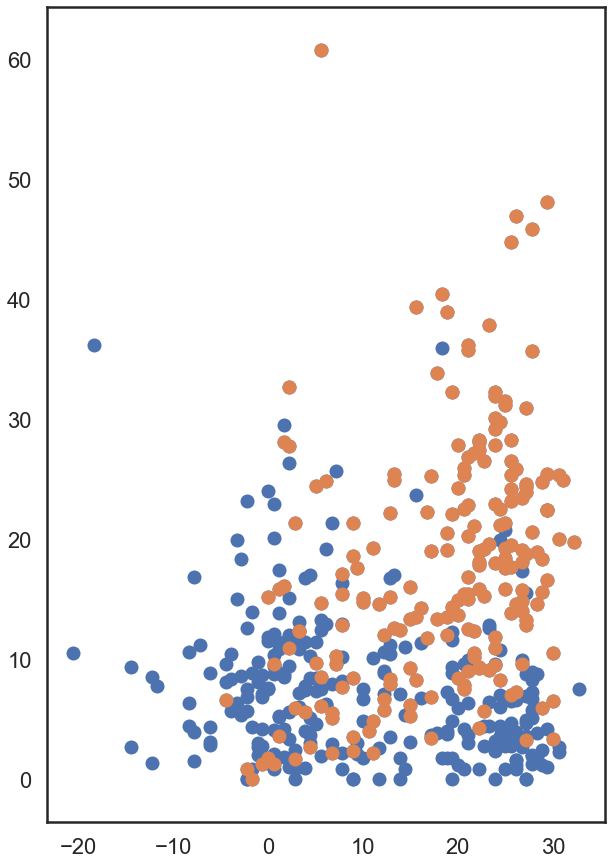

In [440]:
plt.figure(figsize=[10, 15])
p = plt.scatter(df3['TOBS'], df3['Net Revenue'])
p = plt.scatter(reduced_df['TOBS'], reduced_df['Net Revenue'])

In [ ]:
plt.plot(df3['TOBS'])
plt.plot(df3['Net Revenue'])

# weather was not strongly predictive of revenue during covid
For now we will leave temperature out of the forecasting model as it seems complicated

# Is weekend a predictor of revenue?

In [468]:
df3 = (df['Net Revenue']
       .resample('1D')
       .sum()
       .reset_index()
)

In [469]:
df3['weekday'] = df3['Date'].apply(lambda x: x.weekday())

In [470]:
df3['is_weekend'] = df3['weekday'].apply(lambda x: 1 if (x == 6 or x == 0) else 0)


In [471]:
df3

,Date,Net Revenue,weekday,is_weekend
0,2020-06-25,4.41,3,0
1,2020-06-26,3.66,4,0
2,2020-06-27,3.61,5,0
3,2020-06-28,1.19,6,1
4,2020-06-29,5.79,0,1
...,...,...,...,...
449,2021-09-17,39.33,4,0
450,2021-09-18,32.26,5,0
451,2021-09-19,19.61,6,1
452,2021-09-20,19.29,0,1


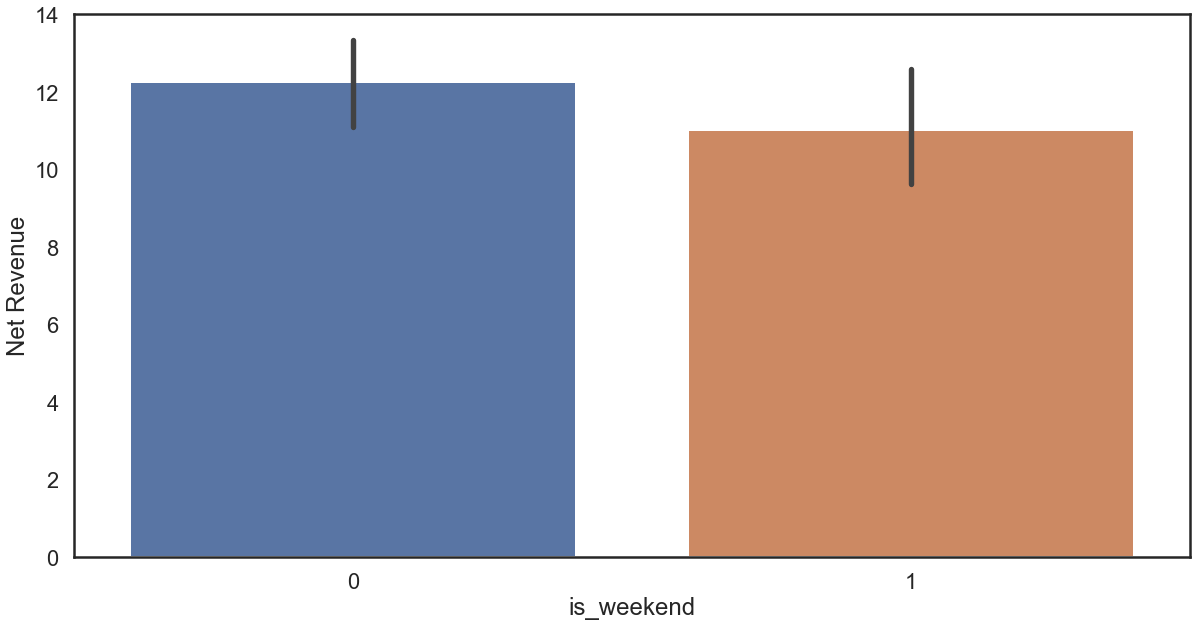

In [474]:
sns.barplot(data = df3, x = 'is_weekend', y = 'Net Revenue');


In [449]:
# Correlation between working_day feature and the number of customers per day
# using the Kruskal Wallis H test for correlations between a continuous and categorical variable
# It is used for comparing two or more independent samples of equal or different sample sizes.
kruskal(df3['is_weekend'], df3['Net Revenue'])

KruskalResult(statistic=648.6700520064156, pvalue=4.348596401707682e-143)

In [452]:
df3.groupby('is_weekend')['Net Revenue'].median()

is_weekend
0    9.44
1    9.32
Name: Net Revenue, dtype: float64

# lag variables
these plots help determine the ARIMA parameters

In [462]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

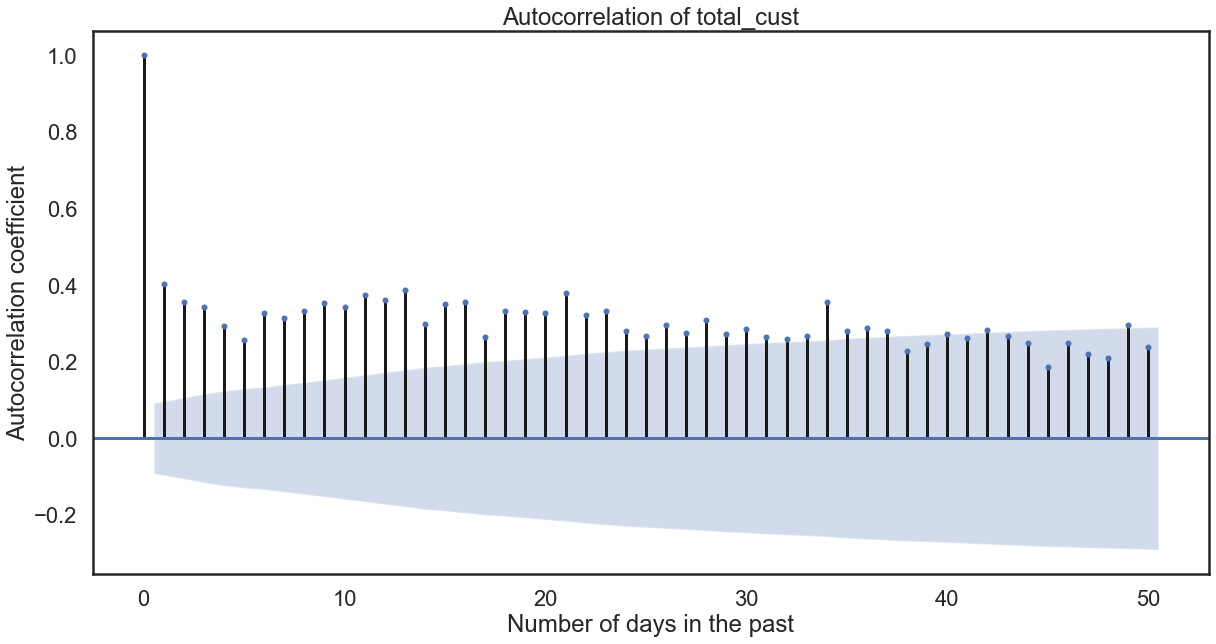

In [464]:
plot_acf(df3['Net Revenue'], lags=50, title='Autocorrelation of total_cust',)
plt.xlabel('Number of days in the past')
plt.ylabel('Autocorrelation coefficient')
plt.show()

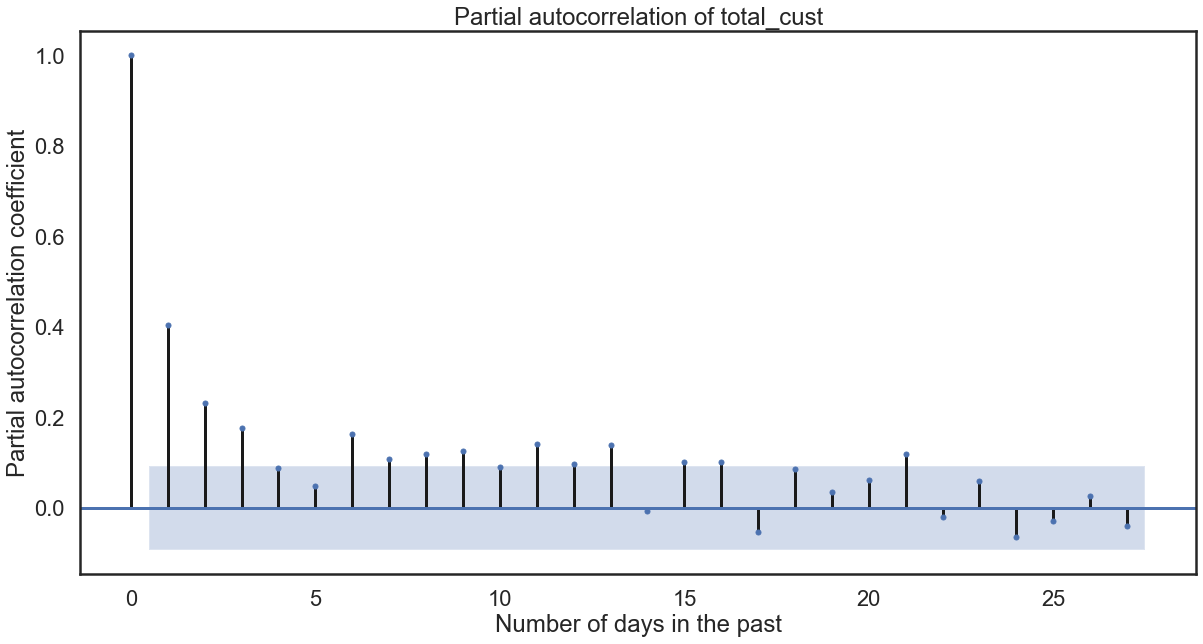

In [466]:
# plotting the partial autocorrelation for target
plot_pacf(df3['Net Revenue'], title='Partial autocorrelation of total_cust',)
plt.xlabel('Number of days in the past')
plt.ylabel('Partial autocorrelation coefficient')
plt.show()



# Covid case counts are a strong predictor of revenue
cases started going down in April-May 2021 and increased by $12/day, which was equivalent to the increase seen over the last year during covid (July 2020 - April 2021). Covid obviously slowed down the growth of these stations

In [599]:
df3 = (df[['Net Revenue', 'cases_per_100k']]
       .resample('1D')
       .agg({'Net Revenue': 'sum', 'cases_per_100k': 'max'})
)
df3 = df3.fillna(method="bfill")

In [600]:
# 7-day rolling window
df3["Net Revenue"] = df3['Net Revenue'].\
                         transform(lambda x: x.rolling('14D', closed='both', center=True).mean())

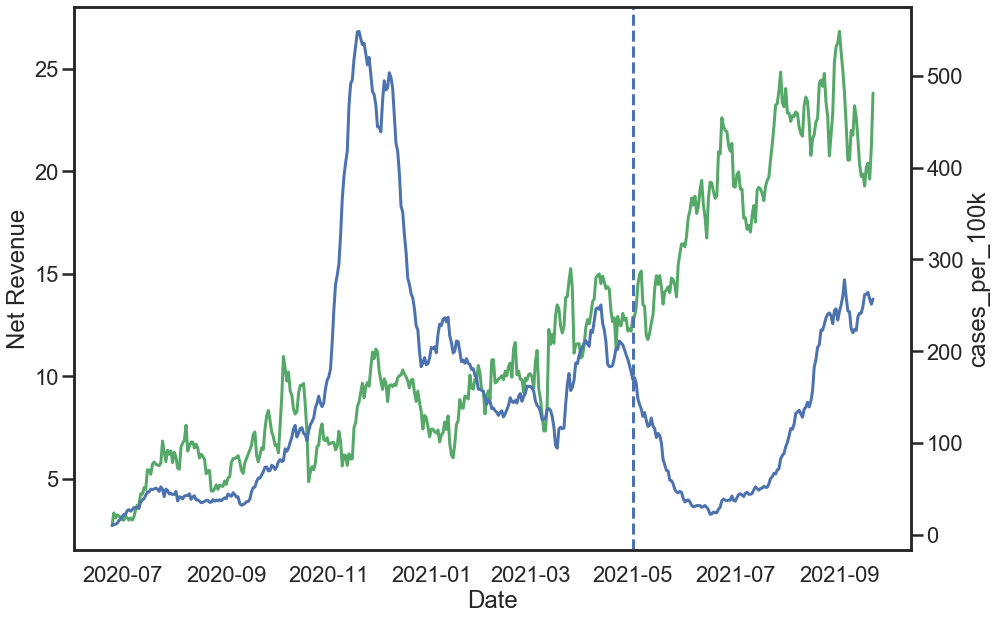

In [601]:
plt.subplots(figsize=[15, 10])
sns.lineplot(data=df3["Net Revenue"], color="g")
ax2 = plt.twinx()
sns.lineplot(data=df3['cases_per_100k'], color="b", ax=ax2)
plt.axvline(x=datetime.datetime(2021,5,1), ls='--')

### Negative correlation between covid cases and Net revenue 

In [607]:
pearsonr(df3["Net Revenue"][100:], df3['cases_per_100k'][100:])

(-0.3490982639377366, 1.391127552248687e-11)

In [609]:
df3.iloc[100]

Net Revenue        7.596000
cases_per_100k    81.753192
Name: 2020-10-03 00:00:00, dtype: float64

# what feature related to covid should be included in the time series forecasting model?